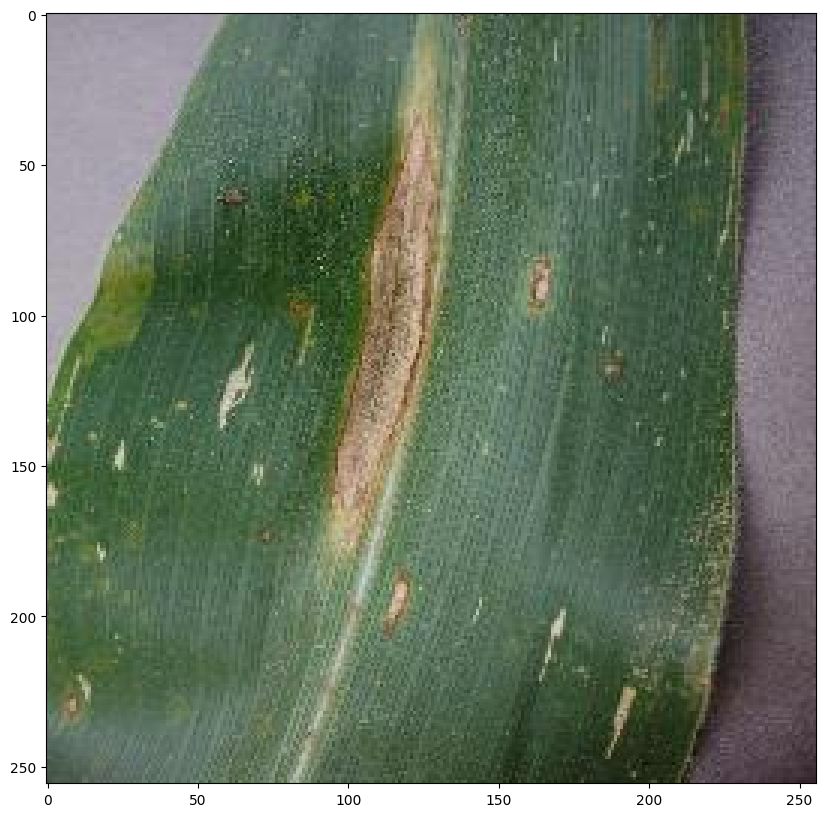

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = '../data/Blight/Corn_Blight (223).JPG'
cv2image = cv2.imread(image)

def show_image(image):
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

show_image(cv2image)

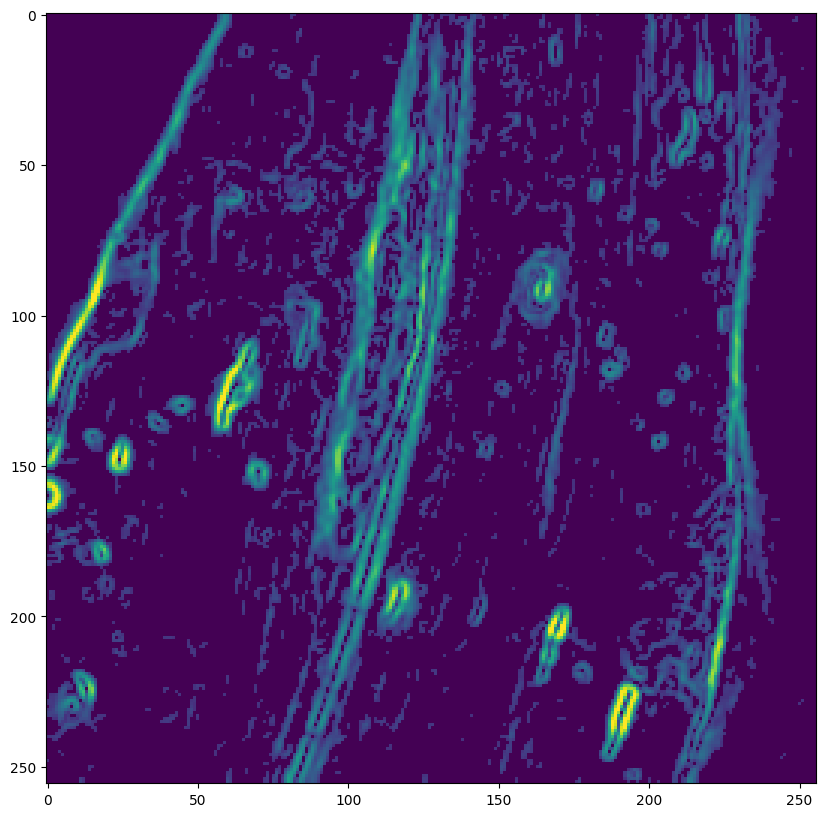

In [2]:
def edge_detect(image):
    sobelX = cv2.Sobel(image, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(image, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)

    sobel[sobel > 255] = 255

    return sobel

def find_edge(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edge_img = np.max( np.array([edge_detect(blurred[:,:,0]),edge_detect(blurred[:,:,1]),edge_detect(blurred[:,:,2])]), axis=0)

    mean = np.mean(edge_img) * 1.05
    edge_img[edge_img < mean] = 0
    return edge_img

# def find_edge(image):
#     blurred = cv2.GaussianBlur(image, (5, 5), 0)
#     edges = cv2.Canny(blurred, 50, 150)  # Using Canny edge detector
#     return edges

edge_img = find_edge(cv2image)
show_image(edge_img)

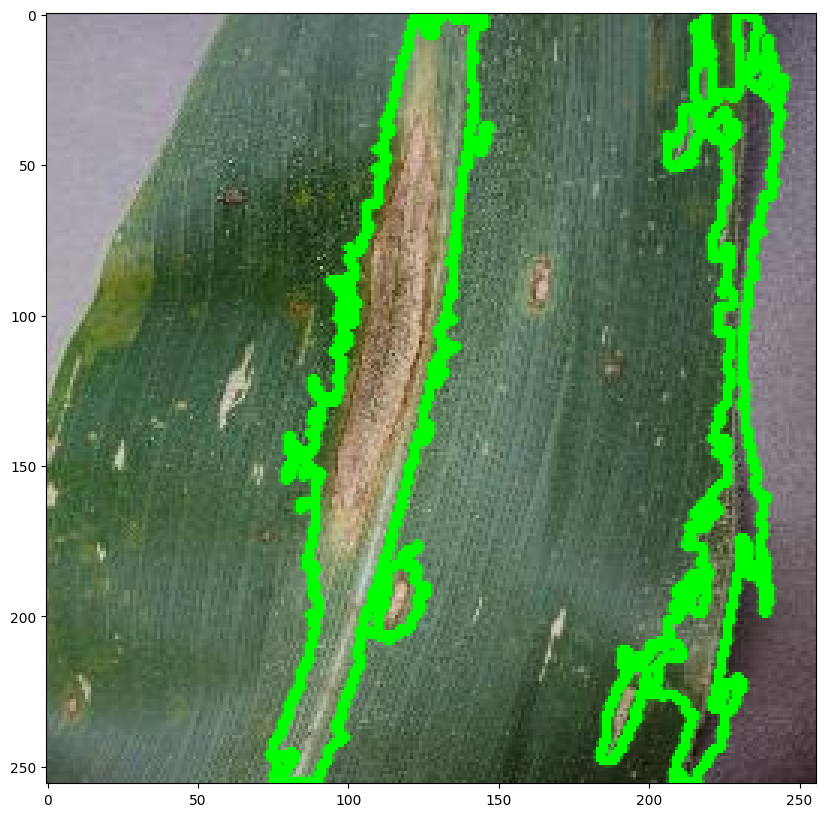

In [3]:
# def find_contours(image, edge_img):
#     contours, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     return contours

def find_contours(image, edge_img):
    contours, hierarchy = cv2.findContours(edge_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    level1 = []
    for i, tupl in enumerate(hierarchy[0]):
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            level1.append(tupl)
    significant = []
    too_small = edge_img.size * 5 / 100
    for tupl in level1:
        contour = contours[tupl[0]]
        area = cv2.contourArea(contour)
        if area > too_small:
            significant.append([contour, area])
            cv2.drawContours(image, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
    
    significant = sorted(significant, key=lambda x: x[1])
    return [x[0] for x in significant]

edge_img_8u = np.asarray(edge_img, np.uint8)
contours = find_contours(cv2image, edge_img_8u)

contour_image = cv2image
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

show_image(contour_image)

In [ ]:
removePercentage = 0.05

def create_mask(image, contours):
    
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    for y in range(mask.shape[0]):
        start = None
        for x in range(mask.shape[1]):
            if mask[y, x].tolist() == [255, 255, 255]:
                if start is None:
                    start = x
                else:
                    for i in range(start + 1, x):
                        mask[y, i] = [255, 255, 255]
                    start = x


    

    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x].tolist() == [255, 255, 255]:
                for i in range(x, min(mask.shape[1], x + int(mask.shape[1] * removePercentage))):
                    mask[y, i] = [0, 0, 0]
                break
        
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1] - 1, 0, -1):
            if mask[y, x].tolist() == [255, 255, 255]:
                for i in range(x, x - int(mask.shape[1] * removePercentage), -1):
                    mask[y, i] = [0, 0, 0]
                break

    return mask
    

mask = create_mask(cv2.imread(image), contours)
show_image(mask)

In [ ]:
def create_grabcut_mask(image, mask, contours):
    # Create a temporary mask with all pixels set to probable background
    temp_mask = np.zeros(image.shape[:2], np.uint8)
    temp_mask[:] = cv2.GC_PR_BGD

    # Set the contour region as probable foreground
    cv2.drawContours(temp_mask, contours, -1, cv2.GC_PR_FGD, thickness=cv2.FILLED)

    # Run grabCut algorithm to refine the mask
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, temp_mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

    # Update the mask based on the refined grabCut result
    mask[temp_mask == cv2.GC_PR_FGD] = [255, 255, 255]
    mask[temp_mask == cv2.GC_FGD] = [255, 255, 255]
    mask[temp_mask == cv2.GC_BGD] = [0, 0, 0]

    return mask

grabcut_mask = create_grabcut_mask(cv2image, mask, contours)
show_image(grabcut_mask)

In [ ]:
def apply_mask(image, mask):
    mask_area = 0
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x, y].tolist() == [255, 255, 255]:
                mask_area += 1
    total_area = mask.shape[0] * mask.shape[1]
    print(mask_area / total_area)
    # if mask_area / total_area < 0.2:
    #     return image
    masked = cv2.bitwise_and(image, mask)
    return masked

masked = apply_mask(cv2.imread(image), grabcut_mask)
show_image(masked)

In [ ]:
masked_image_path = "segdata/" + "/".join(image.split("/")[1:])
cv2.imwrite(masked_image_path, masked)